In [1]:
import os
from pathlib import Path

from src import dino

# Set constants here
W = 0.85
A = 1
B = 1
C = 1
D = 1
SCALE_NORMALIZED = True

# Output directory (_output is ignored by git)
OUTPUT_DIR = "_output"
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print("Created output directory:", OUTPUT_DIR)


IMAGE_DIR = Path("images")
def file_to_brightness(file_path, white_nits=200):
    image = dino.read_image(file_path)
    L = dino.rgb_to_relative_luminance(image)
    L *= white_nits
    return dino.dn_brightness_model(
        L,
        w=W,
        a=A,
        b=B,
        c=C,
        d=D,
        scale_normalized_constants=SCALE_NORMALIZED,
    )

In [10]:
from src import plotting

## Apply model to all illusions
ILLUSION_IMAGES = [
    #"constant_bars.png",
    #"macbeths.png",
    #"mondrian.png",
    "ramp_bar.png",
    #"ramp_squares.png",
    #"whites.png",
]

for image in ILLUSION_IMAGES:
    brightness = file_to_brightness(str(IMAGE_DIR / image))
    filename = f"{os.path.splitext(image)[0]}_w={W}_a={A}_b={B}_c={C}_d={D}_scale-normalized={SCALE_NORMALIZED}.html"
    plotting.image_height_plot(
        brightness,
        output_path=os.path.join(OUTPUT_DIR, filename),
        display=False,
    )
    print("Exported brightness response for", image)

Exported brightness response for ramp_bar.png


  0%|          | 0/3 [00:00<?, ?it/s]

Exported _output/ramp_squares.pdf
Exported _output/ramp_bar.pdf
Exported _output/whites.pdf


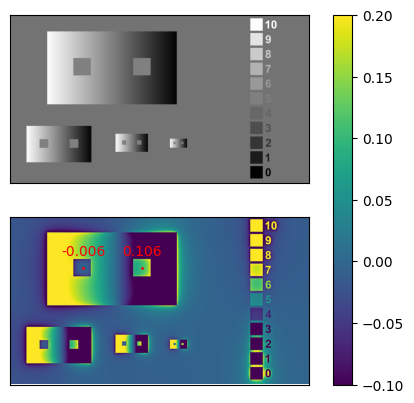

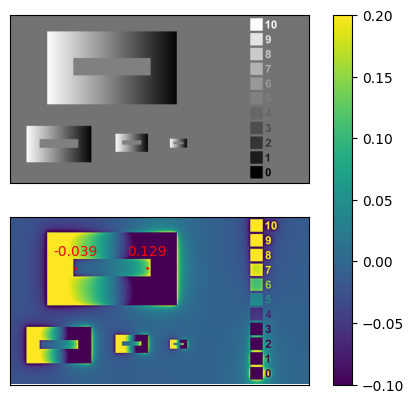

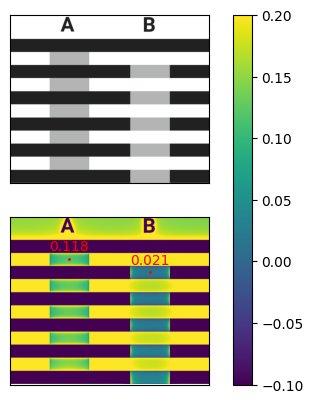

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from tqdm.auto import tqdm


IMAGE_POINTS_OF_INTEREST = {
    "ramp_squares.png": [
        (470, 330), (850, 330),
        
    ],
    "ramp_bar.png": [
        (420, 330), (880, 330),
    ],
    "whites.png": [
        (570, 410), (1350, 540),
    ],
}
for image, pois in tqdm(IMAGE_POINTS_OF_INTEREST.items()):
    image_path = str(IMAGE_DIR / image)
    fig, axs = plt.subplots(2, 1)
    upper, lower = axs
    original_img = mpimg.imread(image_path)
    upper.imshow(original_img, cmap="Greys", aspect="equal")
    brightness = file_to_brightness(image_path)
    norm = Normalize(vmin=-0.1, vmax=0.2, clip=True)
    im = lower.imshow(brightness, cmap="viridis", norm=norm, aspect="equal")
    fig.colorbar(im, ax=axs.ravel().tolist())
    for px, py in pois:
        lower.plot(px, py, marker=".", color="red", markersize=2)
        lower.text(
            px, py-80,
            str(round(brightness[py,px], 3)),
            color="red",
            fontsize=10,
            horizontalalignment="center",
        )
    for ax in axs:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
    file_path = Path("_output") / f"{(IMAGE_DIR / image).stem}.pdf"
    fig.savefig(file_path, bbox_inches="tight", dpi=300, transparent=True)
    print(f"Exported {file_path}")